<a href="https://colab.research.google.com/github/summermccune/Tokenization-Testing-for-Malware-Data/blob/main/Tokenization_Malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow_text
import nltk
nltk.download('punkt')
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/NSF REU/malware")
!ls

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
4Families.csv  OnLineGames.csv	top31_test.csv	 train_4fams.csv  Winwebsec.csv
FakeRean.csv   test_4fams.csv	top31_train.csv  Vobfus.csv


In [52]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tokenizers import Tokenizer, ByteLevelBPETokenizer, SentencePieceBPETokenizer
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from transformers import PreTrainedTokenizerFast
# !pip install datasets
from datasets import load_dataset

### Use to read in, concatenate, and save malware family data ###

In [ ]:
families = ['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec']
all_data = pd.DataFrame(columns=['File', 'Label', 'Opcodes'])
data = {}

for family in families:
  df = pd.read_csv(family+'.csv')
  # data[family] = df
  all_data = pd.concat([all_data, df])

In [ ]:
print(pd.unique(all_data.Label))
print(all_data.shape)
all_data.head()
all_data.to_csv("4Families.csv", index=False)

### Shortcut to read in 4 families saved csv file ###

In [3]:
all_data = pd.read_csv("4Families.csv")

### Split training/testing data ###

In [4]:
x_train,x_test,y_train,y_test=train_test_split(all_data['Opcodes'], all_data['Label'], test_size=0.2, random_state=7, stratify=all_data['Label'])
print(y_test.value_counts())
print(y_train.value_counts())
print(x_train.head(), y_train.head())
print(x_test.head(), y_test.head())

Label
OnLineGames    200
Winwebsec      200
Vobfus         200
FakeRean       200
Name: count, dtype: int64
Label
OnLineGames    800
Vobfus         800
Winwebsec      800
FakeRean       800
Name: count, dtype: int64
1858    mov inc and and add in sub movsl in fnstsw inc...
1012    mov inc and and add in sub movsl in fnstsw inc...
2752    arpl aaa jae popf sub lret aaa jae int3 aaa ja...
2693    jg mov jb add mov jb lret mov jb or jb int3 mo...
3539    loope stos loop dec cmc pusha push mov sub pus...
Name: Opcodes, dtype: object 1858    OnLineGames
1012    OnLineGames
2752         Vobfus
2693         Vobfus
3539      Winwebsec
Name: Label, dtype: object
1524    mov inc and and add in sub movsl in fnstsw inc...
3558    push mov mov jmp in add repz mov mov mov add a...
2003    ljmp jb add mov jb push jb add movsb jb mov mo...
2203    std mov movsb jb jo jb jne jb jne jb jbe jb mo...
1173    mov inc and and add in sub movsl in fnstsw inc...
Name: Opcodes, dtype: object 1524    OnLineGames

In [7]:
train_4fams = pd.DataFrame(list(zip(y_train, x_train)), columns=['Label', 'Opcodes'])
test_4fams = pd.DataFrame(list(zip(y_test, x_test)), columns=['Label', 'Opcodes'])

train_4fams.to_csv('train_4fams.csv', index=False)
test_4fams.to_csv('test_4fams.csv', index=False)


### Separate Dataset for Families ###

In [ ]:
print(data.keys())
frx_train, frx_test, fry_train, fry_test = train_test_split(data['FakeRean']['Opcodes'], data['FakeRean']['Label'], test_size=0.2, random_state=7)
olgx_train, olgx_test, olgy_train, olgy_test = train_test_split(data['OnLineGames']['Opcodes'], data['OnLineGames']['Label'], test_size=0.2, random_state=7)
vfx_train, vfx_test, vfy_train, vfy_test = train_test_split(data['Vobfus']['Opcodes'], data['Vobfus']['Label'], test_size=0.2, random_state=7)
wwsx_train, wwsx_test, wwsy_train, wwsy_test = train_test_split(data['Winwebsec']['Opcodes'], data['Winwebsec']['Label'], test_size=0.2, random_state=7)

dict_keys(['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec'])


In [ ]:
x_train = pd.concat([frx_train, olgx_train, vfx_train, wwsx_train])
x_test = pd.concat([frx_test, olgx_test, vfx_test, wwsx_test])
y_train = pd.concat([fry_train, olgy_train, vfy_train, wwsy_train])
y_test = pd.concat([fry_test, olgy_test, vfy_test, wwsx_test])
print(x_train)
print(y_train)
print(x_test)
print(y_test)

600    push mov push call pop ret push mov sub push p...
80     push push call pop mov and add mov sub cmpw mo...
158    add add add call movl mov add call mov call re...
423    inc xchg add add xchg add add mov add lods xch...
747    neg sbb and add mov js andl push push lea push...
                             ...                        
579    push mov mov in out call inc out inc lock repn...
502    push mov sub push mov movl movl movl movl movl...
537    push mov sub mov mov pop ret push mov sub push...
196    push mov sub push push push movl movl movl mov...
175    mov pusha push mov sub push pushl push pushl c...
Name: Opcodes, Length: 3200, dtype: object
600     FakeRean
80      FakeRean
158     FakeRean
423     FakeRean
747     FakeRean
         ...    
579    Winwebsec
502    Winwebsec
537    Winwebsec
196    Winwebsec
175    Winwebsec
Name: Label, Length: 3200, dtype: object
778    add add add call mov call ret int3 int3 int3 i...
334    fstpl lods sti in ret ja xchg out test

### Tokenization Tests ###

####Single Words: Most common; M=31 (white space separation) ####

In [ ]:
# Single Words: Most common; M=31 (white space separation)
def topX(max, series):
  ctr = Counter()
  for row in series:
    ctr.update(row.split())
  top_words = [count[0] for count in ctr.most_common(max)]
  return top_words

tokens_31 = topX(31, x_train)
print(tokens_31)

['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'or', 'dec', 'cmp', 'xor', 'sub', 'and', 'adc', 'lea', 'sbb', 'test', 'out', 'in', 'jmp', 'movl', 'int3', 'ret', 'je', 'imul', 'nop', 'stos', 'lods', 'scas', 'lret', 'jne']


In [ ]:
def removeNonVocab(vocab, series):
  rows = []
  vocab_str = '|'.join(vocab)
  pattern = '\\b((?!\\b( |' + vocab_str + ')\\b).)*\\b'
  for row in series:
    row = re.sub(pattern, '', row)
    # row = re.sub(' +', ' ', row)
    rows.append(row.split())
    # rows.append(row)
  return rows # list of token lists

qrt = len(x_train)//4
print(qrt)

800


In [ ]:
q1 = removeNonVocab(tokens_31, x_train[:qrt])
print(q1[0])

['mov', 'inc', 'and', 'and', 'add', 'in', 'sub', 'in', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'stos', 'stos', 'stos', 'adc', 'stos', 'add', 'and', 'and', 'jmp', 'or', 'mov', 'test', 'mov', 'mov', 'adc', 'and', 'mov', 'xor', 'push', 'pop', 'mov', 'push', 'je', 'mov', 'push', 'call', 'push', 'push', 'in', 'mov', 'pop', 'in', 'dec', 'push', 'ret', 'dec', 'push', 'sub', 'push', 'adc', 'push', 'sub', 'adc', 'cmp', 'jne', 'pop', 'test', 'sbb', 'mov', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'ret', 'xor', 'push', 'cmp', 'mov', 'pop', 'add', 'or', 'add', 'lret', 'in', 'jne', 'scas', 'pop', 'sbb', 'adc', 'mov', 'call', 'add', 'sbb', 'xor', 'test', 'push', 'push', 'inc', 'xchg', 'lret', 'in', 'je', 'dec', 'lret', 'imul', 'pop', 'int3', 'inc', 'add', 'xchg', 'cmp', 'mov', 'ret', 'pop', 'mov', 'imul', 'imul', 'imul', 'imul', 'mov', 'push', 'dec', 'mov', 'xor', 'or', 'push', 'push', 'add', 'push', 'call', 'push', 'mov', 'push', 'mov', 'push', 'pop', 'mov', 'add', 'cmp', 'xor', 'adc',

In [ ]:
q2 = removeNonVocab(tokens_31, x_train[qrt: 2*qrt])
print(q2[0])

['xchg', 'mov', 'push', 'add', 'xchg', 'push', 'mov', 'push', 'mov', 'mov', 'push', 'mov', 'sbb', 'jne', 'dec', 'mov', 'ret', 'mov', 'mov', 'cmp', 'mov', 'pop', 'mov', 'dec', 'mov', 'mov', 'mov', 'or', 'mov', 'jne', 'xchg', 'mov', 'mov', 'push', 'mov', 'xchg', 'mov', 'mov', 'jne', 'mov', 'mov', 'xchg', 'mov', 'ret', 'mov', 'mov', 'xor', 'inc', 'mov', 'mov', 'mov', 'add', 'pop', 'mov', 'mov', 'sbb', 'push', 'mov', 'dec', 'mov', 'push', 'mov', 'cmp', 'mov', 'mov', 'mov', 'add', 'mov', 'xchg', 'mov', 'adc', 'out', 'mov', 'xor', 'dec', 'mov', 'mov', 'mov', 'jne', 'lea', 'mov', 'mov', 'mov', 'out', 'mov', 'mov', 'mov', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'sub', 'inc', 'add', 'add', 'add', 'inc', 'add', 'add', 'add', 'inc', 'add', 'inc', 'add', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'mov', 'inc', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'ret', 

In [ ]:
q3 = removeNonVocab(tokens_31, x_train[qrt*2:qrt*3])
print(q3[0])

 xor add xor add xor add xor add xor add xor add add add add add add out xor add xor add xor add xor add add add add pop xor add add xor add add add add add xor add xor add add xor add xor add add cmp add add add add push add push xor add add sub add mov add adc add add add xor add dec dec inc and add add and add add je pop inc jne je je push inc je pop dec and jne add dec and jne pop push add add add pop add add add cmp xor xor add add add add add dec dec add add inc push sub push push inc and add dec xor add add xor add xor add push push add pop xor pop add add add push mov sub push push push push pop mov lea push pop mov lea push pop lea movl push lea push push mov mov call test jne mov push mov lea push push call add lea mov push lea push lea push lea push push call test jne lea push lea push lea push push call add lea push lea push push call test jne lea movl push lea push lea push push push call test jne lea push call pop test pop jne mov mov call lea push push call add lea push 

In [ ]:
q4 = removeNonVocab(tokens_31, x_train[qrt*3: qrt*4])
print(q4[0])

 xor add xor add xor add xor add xor add xor add add add add add add out xor add xor add xor add xor add add add add pop xor add add xor add add add add add xor add xor add add xor add xor add add cmp add add add add push add push xor add add sub add mov add adc add add add xor add dec dec inc and add add and add add je pop inc jne je je push inc je pop dec and jne add dec and jne pop push add add add pop add add add cmp xor xor add add add add add dec dec add add inc push sub push push inc and add dec xor add add xor add xor add push push add pop xor pop add add add push mov sub push push push push pop mov lea push pop mov lea push pop lea movl push lea push push mov mov call test jne mov push mov lea push push call add lea mov push lea push lea push lea push push call test jne lea push lea push lea push push call add lea push lea push push call test jne lea movl push lea push lea push push push call test jne lea push call pop test pop jne mov mov call lea push push call add lea push 

In [ ]:
# remain_train_tokens = [*q1, *q2, *q3, *q4]
remain_train_tokens = [*q1, *q2]
train_top31 = pd.DataFrame(list(zip(y_train, remain_train_tokens)), columns=['Label', 'Opcodes'])
print(train_top31.shape)
train_top31.head()

(1600, 2)


Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, in, push, p...
1  OnLineGames  [mov, inc, and, and, add, in, sub, in, push, p...
2       Vobfus  [sub, lret, int3, cmp, jne, jne, jne, mov, pop...
3       Vobfus  [mov, add, mov, lret, mov, or, int3, mov, int3...
4    Winwebsec  [stos, dec, push, mov, sub, push, push, call, ...

In [ ]:
train_top31.to_csv('top31_train.csv', index=False)

In [ ]:
hlf = len(x_test) // 2
test_h1 = removeNonVocab(tokens_31, x_test[:hlf])

In [ ]:
test_h2 = removeNonVocab(tokens_31, x_test[hlf:])

In [ ]:
remain_test_tokens = [*test_h1, *test_h2]
test_top31 = pd.DataFrame(list(zip(y_test, remain_test_tokens)), columns=['Label', 'Opcodes'])
# test_top31.to_csv('top31_test.csv', index=False)
test_top31.head()

Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, in, push, p...
1    Winwebsec  [push, mov, mov, jmp, in, add, mov, mov, mov, ...
2       Vobfus  [add, mov, push, add, mov, mov, mov, sub, mov,...
3       Vobfus  [mov, jne, jne, mov, mov, mov, mov, mov, mov, ...
4  OnLineGames  [mov, inc, and, and, add, in, sub, in, push, p...

##### Shortcut to import already-dropped-token samples #####

In [ ]:
train_top31 = pd.read_csv('top31_train.csv')
# train_top31['new_column'] = train_top31['Opcodes'].apply(lambda x: ast.literal_eval(x))
# test_top31 = pd.read_csv('top31_test.csv')
train_top31.head()

TypeError: dtype '<class 'tuple'>' not understood

In [ ]:
test_top31.head()

Label                                            Opcodes
0  OnLineGames  ['mov', 'inc', 'and', 'and', 'add', 'in', 'sub...
1    Winwebsec  ['push', 'mov', 'mov', 'jmp', 'in', 'add', 'mo...
2       Vobfus  ['add', 'mov', 'push', 'add', 'mov', 'mov', 'm...
3       Vobfus  ['mov', 'jne', 'jne', 'mov', 'mov', 'mov', 'mo...
4  OnLineGames  ['mov', 'inc', 'and', 'and', 'add', 'in', 'sub...

#### Word Pair: Most common; M=31 (overlapped; i.e. bigrams) ####

In [ ]:
# Word Pair: Most common; M=31 (overlapped; i.e. bigrams)


mov inc and and add in sub in push push push pop xor lea stos stos stos adc stos add and and jmp or mov test mov mov adc and mov xor push pop mov push je mov push call push push in mov pop in dec push ret dec push sub push adc push sub adc cmp jne pop test sbb mov pop pop pop push pop pop pop ret xor push cmp mov pop add or add lret in jne scas pop sbb adc mov call add sbb xor test push push inc xchg lret in je dec lret imul pop int3 inc add xchg cmp mov ret pop mov imul imul imul imul mov push dec mov xor or push push add push call push mov push mov push pop mov add cmp xor adc mov pop je inc add cmp jmp mov imul add lea push adc out scas in mov movl mov xor mov in out out xor pop xor in imul out xor call jmp adc or pop cmp push cmp jne push push sub dec mov pop pop add or ret nop inc inc push mov in jmp inc mov push sbb test xor mov jne xor cmp or pop or push out and or test mov je mov in jmp push mov pop push adc lret xor xor dec add sub adc sub jmp xor or in mov dec xchg imul push 

#### Methods for BPE, WPC, UNI

In [47]:
# General tokenizer trainer setup
unk_token = "<UNK>"
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>"]

def prepare_tokenizer_trainer(alg):
    """
    Prepares the tokenizer and trainer with unknown & special tokens.
    """
    if alg == 'BPE':
        tokenizer = Tokenizer(BPE(unk_token = unk_token))
        trainer = BpeTrainer(special_tokens = spl_tokens, vocab_size=100)
    elif alg == 'UNI':
        tokenizer = Tokenizer(Unigram())
        trainer = UnigramTrainer(unk_token= unk_token, special_tokens = spl_tokens, vocab_size=100)
    elif alg == 'WPC':
        tokenizer = Tokenizer(WordPiece(unk_token = unk_token))
        trainer = WordPieceTrainer(special_tokens = spl_tokens, vocab_size=100)

    tokenizer.pre_tokenizer = Whitespace()
    return tokenizer, trainer

def train_tokenizer(alg):
    """
    Trains the tokenizer.
    """
    tokenizer, trainer = prepare_tokenizer_trainer(alg)
    tokenizer.train_from_iterator(batch_iterator('train'), trainer=trainer)
    tokenizer.save("./" + alg + "-trained.json")
    tokenizer = Tokenizer.from_file("./" + alg + "-trained.json")
    return tokenizer

batch_size = 1000
data_files = {"train": "train_4fams.csv", "test": "test_4fams.csv"}
dataset = load_dataset("csv", data_files=data_files)

def batch_iterator(data):
    for i in range(0, len(dataset), batch_size):
        yield dataset[data]['Opcodes'][i : i + batch_size]


#### Character BPE

In [37]:
# Character BPE
BPE_tokenizer = train_tokenizer('BPE')

In [39]:
print(dataset['test']['Opcodes'][0])
output = BPE_tokenizer.encode(dataset['test']['Opcodes'][0])
print(output.tokens)

mov inc and and add in sub movsl in fnstsw incl push push push pop xor lea lock stos stos stos adc int stos add and and jmp or sti ljmp mov dec dec add xor test mov jle jg push mov adc and mov lea pushl movzbl push je mov push call push push mov push mov inc inc dec mov imul sub add mov dec pop adc cmp sbb pop sbb loope lcall push pop pop pop leave ret xor inc add pop js out adc andl sar mov gs sti mov add or mov jnp mov into adc arpl adc mov popf sbb dec cld jmp js mov addr16 or mov imul stc testb call clc lret in fisttpl add fs cs insb in jne jae out cs push pop icebp adc insb mov je pop mov cmp je fbstp dec rcrb inc push push inc rol cs ret les lds je dec jbe jbe enter imul pop int3 inc int mov into arpl outsl cmp sar mov jbe jb jae mov ret pop mov mov arpl je movsb movsb movsl xor shll dec xor stos lods lods scas scas mov dec xor mov mov insl mov mov fistpll jp daa fs movsb jne push lock jmp lea push add push call cmp ss pop mov mov cld cmpsl mov ret jbe lea pushl adc in pop std mo

#### WordPiece ####

In [40]:
# WordPiece
WPC_tokenizer = train_tokenizer('WPC')

In [45]:
print(dataset['test']['Opcodes'][0])
output = WPC_tokenizer.encode(dataset['test']['Opcodes'][0])
print(output.tokens)

mov inc and and add in sub movsl in fnstsw incl push push push pop xor lea lock stos stos stos adc int stos add and and jmp or sti ljmp mov dec dec add xor test mov jle jg push mov adc and mov lea pushl movzbl push je mov push call push push mov push mov inc inc dec mov imul sub add mov dec pop adc cmp sbb pop sbb loope lcall push pop pop pop leave ret xor inc add pop js out adc andl sar mov gs sti mov add or mov jnp mov into adc arpl adc mov popf sbb dec cld jmp js mov addr16 or mov imul stc testb call clc lret in fisttpl add fs cs insb in jne jae out cs push pop icebp adc insb mov je pop mov cmp je fbstp dec rcrb inc push push inc rol cs ret les lds je dec jbe jbe enter imul pop int3 inc int mov into arpl outsl cmp sar mov jbe jb jae mov ret pop mov mov arpl je movsb movsb movsl xor shll dec xor stos lods lods scas scas mov dec xor mov mov insl mov mov fistpll jp daa fs movsb jne push lock jmp lea push add push call cmp ss pop mov mov cld cmpsl mov ret jbe lea pushl adc in pop std mo

#### Unigram Subword ####

In [46]:
# Unigram (subword)
UNI_tokenizer = train_tokenizer('UNI')

In [49]:
print(dataset['test']['Opcodes'][0])
output = UNI_tokenizer.encode(dataset['test']['Opcodes'][0])
print(output.tokens)

mov inc and and add in sub movsl in fnstsw incl push push push pop xor lea lock stos stos stos adc int stos add and and jmp or sti ljmp mov dec dec add xor test mov jle jg push mov adc and mov lea pushl movzbl push je mov push call push push mov push mov inc inc dec mov imul sub add mov dec pop adc cmp sbb pop sbb loope lcall push pop pop pop leave ret xor inc add pop js out adc andl sar mov gs sti mov add or mov jnp mov into adc arpl adc mov popf sbb dec cld jmp js mov addr16 or mov imul stc testb call clc lret in fisttpl add fs cs insb in jne jae out cs push pop icebp adc insb mov je pop mov cmp je fbstp dec rcrb inc push push inc rol cs ret les lds je dec jbe jbe enter imul pop int3 inc int mov into arpl outsl cmp sar mov jbe jb jae mov ret pop mov mov arpl je movsb movsb movsl xor shll dec xor stos lods lods scas scas mov dec xor mov mov insl mov mov fistpll jp daa fs movsb jne push lock jmp lea push add push call cmp ss pop mov mov cld cmpsl mov ret jbe lea pushl adc in pop std mo

#### SentencePiece ####

In [53]:
# Subword Regularization (SentencePiece package)
SPC_tokenizer = SentencePieceBPETokenizer()
SPC_tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=100)

In [54]:
print(dataset['test']['Opcodes'][0])
output = SPC_tokenizer.encode(dataset['test']['Opcodes'][0])
print(output.tokens)

mov inc and and add in sub movsl in fnstsw incl push push push pop xor lea lock stos stos stos adc int stos add and and jmp or sti ljmp mov dec dec add xor test mov jle jg push mov adc and mov lea pushl movzbl push je mov push call push push mov push mov inc inc dec mov imul sub add mov dec pop adc cmp sbb pop sbb loope lcall push pop pop pop leave ret xor inc add pop js out adc andl sar mov gs sti mov add or mov jnp mov into adc arpl adc mov popf sbb dec cld jmp js mov addr16 or mov imul stc testb call clc lret in fisttpl add fs cs insb in jne jae out cs push pop icebp adc insb mov je pop mov cmp je fbstp dec rcrb inc push push inc rol cs ret les lds je dec jbe jbe enter imul pop int3 inc int mov into arpl outsl cmp sar mov jbe jb jae mov ret pop mov mov arpl je movsb movsb movsl xor shll dec xor stos lods lods scas scas mov dec xor mov mov insl mov mov fistpll jp daa fs movsb jne push lock jmp lea push add push call cmp ss pop mov mov cld cmpsl mov ret jbe lea pushl adc in pop std mo

#### Byte Level BPE

In [55]:
# Byte Level Byte Pair Encoding
BBPE_tokenizer = ByteLevelBPETokenizer()
BBPE_tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=100)

In [56]:
print(dataset['test']['Opcodes'][0])
output = BBPE_tokenizer.encode(dataset['test']['Opcodes'][0])
print(output.tokens)

mov inc and and add in sub movsl in fnstsw incl push push push pop xor lea lock stos stos stos adc int stos add and and jmp or sti ljmp mov dec dec add xor test mov jle jg push mov adc and mov lea pushl movzbl push je mov push call push push mov push mov inc inc dec mov imul sub add mov dec pop adc cmp sbb pop sbb loope lcall push pop pop pop leave ret xor inc add pop js out adc andl sar mov gs sti mov add or mov jnp mov into adc arpl adc mov popf sbb dec cld jmp js mov addr16 or mov imul stc testb call clc lret in fisttpl add fs cs insb in jne jae out cs push pop icebp adc insb mov je pop mov cmp je fbstp dec rcrb inc push push inc rol cs ret les lds je dec jbe jbe enter imul pop int3 inc int mov into arpl outsl cmp sar mov jbe jb jae mov ret pop mov mov arpl je movsb movsb movsl xor shll dec xor stos lods lods scas scas mov dec xor mov mov insl mov mov fistpll jp daa fs movsb jne push lock jmp lea push add push call cmp ss pop mov mov cld cmpsl mov ret jbe lea pushl adc in pop std mo

#### Random Walk Graph ####

In [ ]:
# Random Walk Graph

### Word2Vec Embeddings ###

In [ ]:
#word2vec
model = Word2Vec(train_top31['Opcodes'], vector_size=100, window=30)
x_train_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in train_top31['Opcodes']])
x_test_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in test_top31['Opcodes']])

In [ ]:
print(x_train_embeddings[:2])

[[-0.15661928  0.1065632   0.231594    0.03250815  1.0274106   0.26402617
  -0.94085246 -0.60707426  0.3925949   0.15958296 -0.15987058 -0.94255066
   0.4636184   0.14346522  0.22722234 -1.2260529   0.3097518   0.31090155
  -0.6883157  -0.2790607  -0.89209205 -0.29306087 -0.04131303  1.0364066
  -0.13827902  0.57446456  1.2543703   0.8712692  -0.4086081   0.81910676
   0.7760074  -0.443477   -0.90752125 -0.15169187  0.43246335  0.55154824
   0.02847939 -0.25927272  0.09078007  0.07186756 -0.36291608  0.18112828
  -0.19468533  0.09193683  0.05220998  0.3433398   0.24043074  0.57308143
   0.02660104 -0.6778838  -0.24202493 -0.04804526 -0.44894287 -0.32239842
   0.15849237  0.91363287  0.25186056  0.9454712   0.24920088  0.17501728
  -0.02339416 -0.65331334 -0.8216859   0.25756034 -0.10613154  0.23423699
   0.3936497  -0.63060045  0.21070299  0.405446   -0.29796106 -0.508046
  -0.48800236 -0.4500953  -0.23427172  0.73201996 -0.13532051 -0.5579292
  -0.19258898 -0.07750682  0.04488317  0.2

### Random Forest ###

In [ ]:
#Random Forest
clf = RandomForestClassifier(n_estimators=1000)

clf.fit(x_train_embeddings, train_top31['Label'])
y_pred = clf.predict(x_test_embeddings)

Accuracy: 94.38%


AttributeError: 'Series' object has no attribute 'names'

Accuracy: 94.38%
[[184   3   0  13]
 [  2 189   0   9]
 [  1   0 198   1]
 [ 11   4   1 184]]


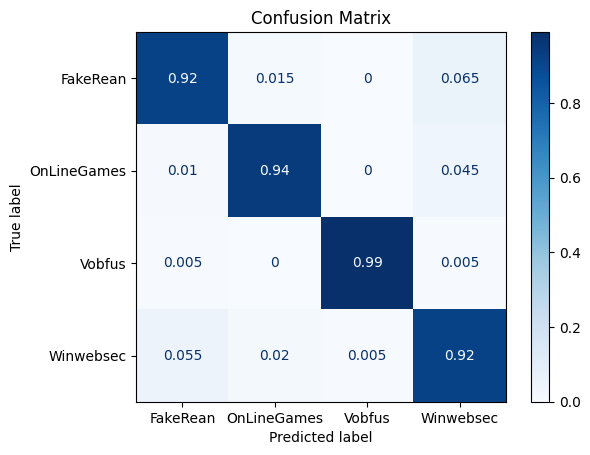

In [ ]:
score=accuracy_score(test_top31['Label'], y_pred)
names = ['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec']
print(f'Accuracy: {round(score*100,2)}%')
cm = confusion_matrix(y_test, y_pred, labels=names)
print(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()